In [1]:
from typing import TypedDict,List,Literal

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
docs=(
    PyPDFLoader("./documents/Company_Policies.pdf").load()+
    PyPDFLoader("./documents/Company_Profile.pdf").load()+
    PyPDFLoader("./documents/Product_and_Pricing.pdf").load()
)

In [3]:
chunks=RecursiveCharacterTextSplitter(chunk_size=600,chunk_overlap=150).split_documents(docs)

In [4]:
embeddings=OpenAIEmbeddings(model="text-embedding-3-large")
vectorstore=FAISS.from_documents(chunks,embeddings)
retriever=vectorstore.as_retriever(search_type="similarity",search_kwargs={"k":4})

In [5]:
llm=ChatOpenAI(model="gpt-4o-mini",temperature=0.0)

In [6]:
class State(TypedDict):
    question:str
    need_retrieval:bool

    docs:List[Document]
    relevant_docs:List[Document]

    context:str
    answer:str

    issup:Literal["fully_supported","partially_supported","no_support"]
    evidence=List[str]

    retries:int

    isuse: Literal["useful", "not_useful"]
    use_reason: str

In [7]:
class RetreieveDecision(BaseModel):
    should_retrieve:bool=Field(description="True if external documents are needed to answer reliably,else False .")

decide_retrieval_prompt=ChatPromptTemplate.from_messages(
    [
     ("system","You decide whether retrieval is needed.\n Return JSON that matches this schema:\n {{'should retrive':boolean}}\n\n Guidelines:\n -should_retrueve=True if answering requires specific facts, citations, or info likely not in the model.\n -should-retrive=False for general  explanations, definitions, or reasoning that doesn't need sources.\n -If unsure, Choose True"),
     ("human","Question:{question}")  , 
    ]
)

should_retrieve_llm=llm.with_structured_output(RetreieveDecision)

def decide_retrieval(state:State)->State:
    decide=(decide_retrieval_prompt|should_retrieve_llm).invoke({"question":state["question"]}).should_retrieve

    return {"need_retrieval":decide}

In [8]:
direct_generation_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","Answer the question using only your general knowledge.\n Do NOT assume access to documents.\n If you are unsure or the answer requires specific sources, say:\n I don't know based on my general knowledge"),
        ("human","{question}")
    ]
)

def generation_direct(state:State):
    out=(direct_generation_prompt|llm).invoke({"question":state["question"]})

    return {"answer":out.content}

In [9]:
def retrieve(state:State):
    return {"docs":retriever.invoke(state["question"])}

In [10]:
class  RelevanceDecision(BaseModel):
    is_relevant:bool=Field(...,description="True if the document helps answer the question, else False")

is_relevant_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","You are judging document relevance:\n Return JSON taht matches this schema:\n {{'is_relevant':boolean}}\n\n A document is relevant if it contains information useful for answering the question."),
        ("human","Question:{question}\n\n Docuemnt:\n {document} ")
    ]
)

relevance_llm=llm.with_structured_output(RelevanceDecision)

def is_relevant(state:State):
     relevant_docs:List[Document]=[]

     for doc in state["docs"]:
          decision=(is_relevant_prompt|relevance_llm).invoke(
               {
                    "question":state["question"],
                    "document":doc.page_content
               }
          )
         
          if decision.is_relevant:
               relevant_docs.append(doc)
            
     return {"relevant_docs":relevant_docs}


In [11]:
# New
rag_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a business RAG assistant.\n"
            "Answer the user's question using ONLY the provided context.\n"
            "If the context does not contain enough information, say:\n"
            "'No relevant document found.'\n"
            "Do not use outside knowledge.\n"
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Context:\n{context}\n"
        ),
    ]
)

def generate_from_context(state: State):
    # Stuff relevant docs into one block
    context = "\n\n---\n\n".join(
        [d.page_content for d in state.get("relevant_docs", [])]
    ).strip()

    if not context:
        return {"answer": "No relevant document found.", "context": ""}

    out = (rag_generation_prompt | llm).invoke(
        {
            "question": state["question"],
            "context": context,
        }
    )
    return {"answer": out.content, "context": context}

In [12]:
def no_answer_found(state:State):
    return {"answer":"No relevant document found.","context":""}

In [13]:
def route_after_decide(state:State)->Literal["generate_direct","retrieve"]:
    if state["need_retrieval"]:
        return "retrieve"
    return "generate_direct"

In [14]:

# New
def route_after_relevance(state: State) -> Literal["generate_from_context", "no_answer_found"]:
    if state.get("relevant_docs") and len(state["relevant_docs"]) > 0:
        return "generate_from_context"
    return "no_answer_found"

In [15]:
class IsSUPDecision(BaseModel):
    issup: Literal["fully_supported", "partially_supported", "no_support"]
    evidence: List[str] = Field(default_factory=list)

issup_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are verifying whether the ANSWER is supported by the CONTEXT.\n"
            "Return JSON with keys: issup, evidence.\n"
            "issup must be one of: fully_supported, partially_supported, no_support.\n\n"
            "How to decide issup:\n"
            "- fully_supported:\n"
            "  Every meaningful claim is explicitly supported by CONTEXT, and the ANSWER does NOT introduce\n"
            "  any qualitative/interpretive words that are not present in CONTEXT.\n"
            "  (Examples of disallowed words unless present in CONTEXT: culture, generous, robust, designed to,\n"
            "  supports professional development, best-in-class, employee-first, etc.)\n\n"
            "- partially_supported:\n"
            "  The core facts are supported, BUT the ANSWER includes ANY abstraction, interpretation, or qualitative\n"
            "  phrasing not explicitly stated in CONTEXT (e.g., calling policies 'culture', saying leave is 'generous',\n"
            "  or inferring outcomes like 'supports professional development').\n\n"
            "- no_support:\n"
            "  The key claims are not supported by CONTEXT.\n\n"
            "Rules:\n"
            "- Be strict: if you see ANY unsupported qualitative/interpretive phrasing, choose partially_supported.\n"
            "- If the answer is mostly unrelated to the question or unsupported, choose no_support.\n"
            "- Evidence: include up to 3 short direct quotes from CONTEXT that support the supported parts.\n"
            "- Do not use outside knowledge."
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Answer:\n{answer}\n\n"
            "Context:\n{context}\n"
        ),
    ]
)

issup_llm = llm.with_structured_output(IsSUPDecision)

def is_sup(state:State):
    decision=(issup_prompt|issup_llm).invoke(
        {
            "question": state["question"],
            "answer": state["answer"],
            "context": state["context"],
        })
    return {"issup": decision.issup, "evidence": decision.evidence}

MAX_RETRIES = 10

def route_after_issup(state: State) -> Literal["accept_answer", "revise_answer"]:
    # accept if fully supported
    if state.get("issup") == "fully_supported":
        return "accept_answer"

    # stop if we've already tried enough
    if state.get("retries", 0) >= MAX_RETRIES:
        return "accept_answer"   # or return a "give_up" node if you want

    # otherwise revise again
    return "revise_answer"

In [16]:
def accept_answer(state:State):
    return {}

In [17]:
revise_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","You are a STRICT reviser.\n\n You must output based on the following format:\n\n FORMAT (quote-only answer):\n -        <direct quote forom the context>\n - <direct quote form the context>\n\n Rules:\n - Use only the context.\n -Do not add any new words besides bullet dashes and the quote themselves.\n -Do not explain anything\n - Do not say 'context','not mentioned','does not mention','not provided',etc.\n"),
        ("human","Question:\n{question}\n\n Current context:\n{answer}\n\n Context:\n{context}\n")
    ]
)

def revise_answer(state:State):
    out=(revise_prompt|llm).invoke(
        {
            "question":state["question"],
            "answer":state["answer"],
            "context":state["context"]
        }
    )
    return {"answer":out.content,"retries": state["retries"] + 1}

In [18]:
class IsUSEDecision(BaseModel):
    isuse: Literal["useful", "not_useful"]
    reason: str = Field(..., description="Short reason in 1 line.")

isuse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are judging USEFULNESS of the ANSWER for the QUESTION.\n\n"
            "Goal:\n"
            "- Decide if the answer actually addresses what the user asked.\n\n"
            "Return JSON with keys: isuse, reason.\n"
            "isuse must be one of: useful, not_useful.\n\n"
            "Rules:\n"
            "- useful: The answer directly answers the question or provides the requested specific info.\n"
            "- not_useful: The answer is generic, off-topic, or only gives related background without answering.\n"
            "- Do NOT use outside knowledge.\n"
            "- Do NOT re-check grounding (IsSUP already did that). Only check: 'Did we answer the question?'\n"
            "- Keep reason to 1 short line."
        ),
        (
            "human",
            "Question:\n{question}\n\nAnswer:\n{answer}"
        ),
    ]
)

isuse_llm = llm.with_structured_output(IsUSEDecision)

def is_use(state: State):
    decision: IsUSEDecision = isuse_llm.invoke(
        isuse_prompt.format_messages(
            question=state["question"],
            answer=state.get("answer", ""),
        )
    )
    return {"isuse": decision.isuse, "use_reason": decision.reason}


def route_after_isuse(state: State) -> Literal["END", "no_answer_found"]:
    if state.get("isuse") == "useful":
        return "END"
    return "no_answer_found"

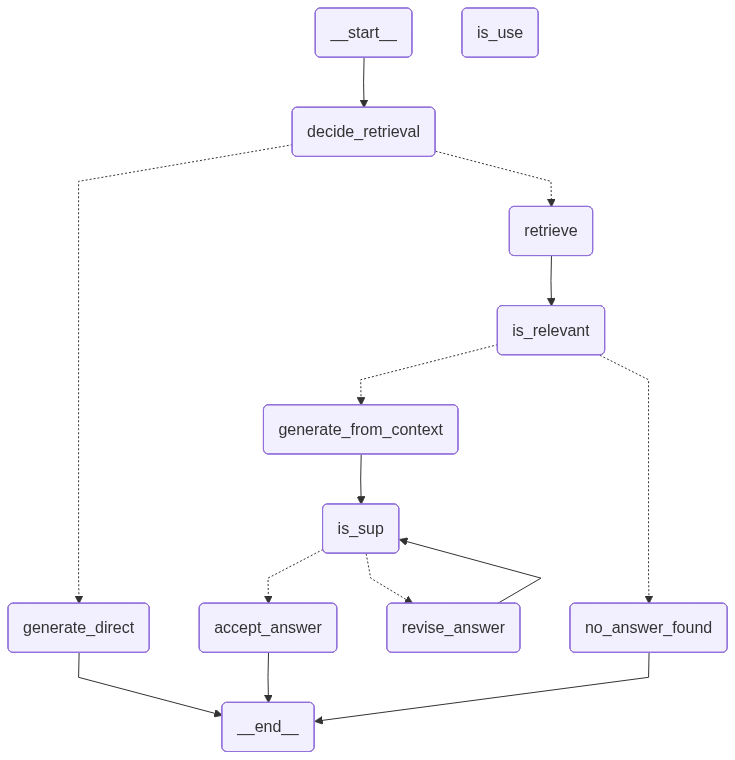

In [19]:
g=StateGraph(State)

g.add_node("decide_retrieval",decide_retrieval)
g.add_node("generate_direct",generation_direct)
g.add_node("retrieve",retrieve)
g.add_node("is_relevant",is_relevant)
g.add_node("generate_from_context", generate_from_context)
g.add_node("no_answer_found", no_answer_found)
g.add_node("is_sup", is_sup)
g.add_node("accept_answer", accept_answer)
g.add_node("revise_answer", revise_answer)
g.add_node("is_use", is_use)

g.add_edge(START,"decide_retrieval")

g.add_conditional_edges(
    "decide_retrieval",route_after_decide,
    {
        "generate_direct":"generate_direct",
        "retrieve":"retrieve"
    }
)
g.add_edge("generate_direct",END)
g.add_edge("retrieve","is_relevant")


g.add_conditional_edges(
    "is_relevant",
    route_after_relevance,
    {
        "generate_from_context": "generate_from_context",
        "no_answer_found": "no_answer_found",
    },
)
g.add_edge("generate_from_context", "is_sup")
g.add_edge("no_answer_found", END)

g.add_conditional_edges(
    "is_sup",
    route_after_issup,  
    {"accept_answer": "accept_answer", "revise_answer": "revise_answer"},
)

g.add_edge("revise_answer", "is_sup")

g.add_conditional_edges(
    "is_use",
    route_after_isuse,
    {
        "END": END,
        "no_answer_found": "no_answer_found",
    },
)  
g.add_edge("accept_answer", END)

app = g.compile()
app

In [20]:
result = app.invoke(
    {
        "question": "Describe NexaAI’s company culture.",
        "docs": [],
        "relevant_docs": [],
        "context": "",
        "answer": "",
        "issup": "",
        "evidence": [],
        "retries": 0,
    },
    config={"recursion_limit": 80},  # ✅ bump limit
)



print("need_retrieval:", result.get("need_retrieval"))
print("#docs:", len(result.get("docs", [])))
print("#relevant_docs:", len(result.get("relevant_docs", [])))
print("issup:", result.get("issup"))
print("evidence:", result.get("evidence"))
print("answer:", result.get("answer"))

need_retrieval: True
#docs: 4
#relevant_docs: 1
issup: fully_supported
evidence: None
answer: -        "NexaAI is committed to maintaining a fair, inclusive, and performance-driven workplace."
-        "Employees are encouraged to maintain a healthy work-life balance."


In [21]:
print("retries:", result.get("retries"))

retries: 1
